In [223]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql
from sqlalchemy import create_engine
import getpass  # To get the password without showing the input
from pyproj import Proj

# data source: 
# https://opendata-ajuntament.barcelona.cat/data/dataset/accidents-vehicles-gu-bcn

In [224]:
# functions definitions

def clean_columns_names (data):
    data.columns = data.columns.str.replace('¢', 'o')
    data.columns = data.columns.str.replace('ó', 'o')
    data.columns = data.columns.str.replace('d\'', '')
    data.columns = data.columns.str.replace('(', '', regex=False)
    data.columns = data.columns.str.replace(')', '', regex=False)
    data.columns = data.columns.str.strip().str.lower()
    data.columns = data.columns.str.replace(' ', '_')
    data.columns = data.columns.str.replace('_de_', '_')
    data = data.rename(columns={'num_postal_caption':'num_postal', 'nk_any':'any', 'numero_expedient':'codi_expedient'})

    return data

def translate_columns_names (data):
    data = data.rename(columns={'codi_expedient':'file_code', 
                                'codi_districte':'district_id',
                                'nom_districte':'district_name',
                                'codi_barri':'neighborhood_id',
                                'nom_barri':'neighborhood_name',
                                'codi_carrer':'street_id',
                                'nom_carrer':'street_name',
                                'num_postal':'postal_code',
                                'descripcio_dia_setmana':'weekday_name',
                                'dia_setmana':'weekday_name_shortcut',
                                'descripcio_tipus_dia':'day_type',
                                'any':'year',
                                'mes_any':'month',
                                'nom_mes':'month_name',
                                'dia_mes':'day',
                                'hora_dia':'hour',
                                'descripcio_causa_vianant':'pedestrian_cause',
                                'descripcio_tipus_vehicle':'vehicle_type',
                                'descripcio_model':'vehicle_model',
                                'descripcio_marca':'vehicle_brand',
                                'descripcio_color':'vehicle_color',
                                'descripcio_carnet':'driving_license',
                                'antiguitat_carnet':'driving_license_antiquity',
                                'coordenada_utm_y':'x_coordinate',
                                'coordenada_utm_x':'y_coordinate',
                                'longitud':'longitude',
                                'latitud':'latitude',
                                'descripcio_torn':'shift'
                               })
    return data

def translate_values (data):
    # vehicle_color column
    data['vehicle_color'] = data['vehicle_color'].replace('Negre','Black')
    data['vehicle_color'] = data['vehicle_color'].replace('Gris','Grey')
    data['vehicle_color'] = data['vehicle_color'].replace('Blanc','White')
    data['vehicle_color'] = data['vehicle_color'].replace('Vermell','Red')
    data['vehicle_color'] = data['vehicle_color'].replace('Blau','Blue')
    data['vehicle_color'] = data['vehicle_color'].replace('Altres','Others')
    data['vehicle_color'] = data['vehicle_color'].replace('Negre/Groc','Black/Yellow')
    data['vehicle_color'] = data['vehicle_color'].replace('Verd','Green')
    data['vehicle_color'] = data['vehicle_color'].replace('Groc','Yellow')
    data['vehicle_color'] = data['vehicle_color'].replace('granate','Black')
    data['vehicle_color'] = data['vehicle_color'].replace('Platejat','Silver')
    data['vehicle_color'] = data['vehicle_color'].replace('Marró','Brown')
    data['vehicle_color'] = data['vehicle_color'].replace('Taronja','Orange')
    data['vehicle_color'] = data['vehicle_color'].replace('Daurat','Golden')
    data['vehicle_color'] = data['vehicle_color'].replace('Violeta','Violet')
    data['vehicle_color'] = data['vehicle_color'].replace('Rosa','Pink')
    
    # weekday_name column
    data['weekday_name'] = data['weekday_name'].replace('Dilluns','Monday')
    data['weekday_name'] = data['weekday_name'].replace('Dimarts','Tuesday')
    data['weekday_name'] = data['weekday_name'].replace('Dimecres','Wednesday')
    data['weekday_name'] = data['weekday_name'].replace('Dijous','Thursday')
    data['weekday_name'] = data['weekday_name'].replace('Divendres','Friday')
    data['weekday_name'] = data['weekday_name'].replace('Dissabte','Saturday')
    data['weekday_name'] = data['weekday_name'].replace('Diumenge','Sunday')
    
    # weekday_name_shortcut column
    data['weekday_name_shortcut'] = data['weekday_name_shortcut'].replace('Dl','Mo')
    data['weekday_name_shortcut'] = data['weekday_name_shortcut'].replace('Dm','Tu')
    data['weekday_name_shortcut'] = data['weekday_name_shortcut'].replace('Dc','We')
    data['weekday_name_shortcut'] = data['weekday_name_shortcut'].replace('Dj','Th')
    data['weekday_name_shortcut'] = data['weekday_name_shortcut'].replace('Dv','Fr')
    data['weekday_name_shortcut'] = data['weekday_name_shortcut'].replace('Ds','Sa')
    data['weekday_name_shortcut'] = data['weekday_name_shortcut'].replace('Dg','Su')
    
    # month column
    data['month'] = data['month'].replace('Gener','January')
    data['month'] = data['month'].replace('Febrer','February')
    data['month'] = data['month'].replace('Març','March')
    data['month'] = data['month'].replace('Abril','April')
    data['month'] = data['month'].replace('Maig','May')
    data['month'] = data['month'].replace('Juny','June')
    data['month'] = data['month'].replace('Juliol','July')
    data['month'] = data['month'].replace('Agost','August')
    data['month'] = data['month'].replace('Setembre','September')
    data['month'] = data['month'].replace('Octubre','October')
    data['month'] = data['month'].replace('Novembre','November')
    data['month'] = data['month'].replace('Desembre','December')
    
    # vehicle_type column
    data['vehicle_type'] = data['vehicle_type'].replace('Motocicleta','Motorcycle')
    data['vehicle_type'] = data['vehicle_type'].replace('Turismo','Car')
    data['vehicle_type'] = data['vehicle_type'].replace('Turisme','Car')
    data['vehicle_type'] = data['vehicle_type'].replace('Furgoneta','Van')
    data['vehicle_type'] = data['vehicle_type'].replace('Ciclomotor','Motorcycle')
    data['vehicle_type'] = data['vehicle_type'].replace('Taxi','Cab')
    data['vehicle_type'] = data['vehicle_type'].replace('Bicicleta','Bicycle')
    data['vehicle_type'] = data['vehicle_type'].replace('Autobús','Bus')
    data['vehicle_type'] = data['vehicle_type'].replace('Camión <= 3,5 Tm','Truck')
    data['vehicle_type'] = data['vehicle_type'].replace('Veh. mobilitat personal amb motor','Others')
    data['vehicle_type'] = data['vehicle_type'].replace('Camió rígid <= 3,5 tones','Truck')
    data['vehicle_type'] = data['vehicle_type'].replace('Camión > 3,5 Tm','Truck')
    data['vehicle_type'] = data['vehicle_type'].replace('Camió rígid > 3,5 tones','Truck')
    data['vehicle_type'] = data['vehicle_type'].replace('Autobús articulat','Bus')
    data['vehicle_type'] = data['vehicle_type'].replace('Tot terreny','All-terrain vehicle')
    data['vehicle_type'] = data['vehicle_type'].replace('Todo terreno','All-terrain vehicle')
    data['vehicle_type'] = data['vehicle_type'].replace('Autocar','Motorcoach')
    data['vehicle_type'] = data['vehicle_type'].replace('Tractocamión','Tractor unit')
    data['vehicle_type'] = data['vehicle_type'].replace('Tractor camió','Tractor unit')
    data['vehicle_type'] = data['vehicle_type'].replace('Otros vehíc. a motor','Others')
    data['vehicle_type'] = data['vehicle_type'].replace('Altres vehicles amb motor','Others')
    data['vehicle_type'] = data['vehicle_type'].replace('Autobús articulado','Bus')
    data['vehicle_type'] = data['vehicle_type'].replace('Veh. mobilitat personal sense motor','Others')
    data['vehicle_type'] = data['vehicle_type'].replace('Tranvía o tren','Tram')
    data['vehicle_type'] = data['vehicle_type'].replace('Tren o tramvia','Tram')
    data['vehicle_type'] = data['vehicle_type'].replace('Cuadriciclo <75cc','Quadricycle')
    data['vehicle_type'] = data['vehicle_type'].replace('Altres vehicles sense motor','Others')
    data['vehicle_type'] = data['vehicle_type'].replace('Maquinaria de obras','Construction machinery')
    data['vehicle_type'] = data['vehicle_type'].replace("Maquinària d'obres i serveis",'Construction machinery')
    data['vehicle_type'] = data['vehicle_type'].replace('Autocaravana','Motorhome')
    data['vehicle_type'] = data['vehicle_type'].replace('Microbus <=17 plazas','Microbus')
    data['vehicle_type'] = data['vehicle_type'].replace('Cuadriciclo >=75cc','Quadricycle')
    data['vehicle_type'] = data['vehicle_type'].replace('Quadricicle < 75 cc','Quadricycle')
    data['vehicle_type'] = data['vehicle_type'].replace('Microbús <= 17','Microbus')
    data['vehicle_type'] = data['vehicle_type'].replace('Pick-up','Pick-up')
    data['vehicle_type'] = data['vehicle_type'].replace('Quadricicle > 75 cc','Quadricycle')
    data['vehicle_type'] = data['vehicle_type'].replace('Carro','Carriage')
    data['vehicle_type'] = data['vehicle_type'].replace('Ambulància','Ambulance')
    data['vehicle_type'] = data['vehicle_type'].replace('Microbus <= 17','Microbus')
    
    return data

def group_vehicle_types (data):
    
    data['vehicle_type'] = data['vehicle_type'].replace('Tractor unit','Truck')
    data['vehicle_type'] = data['vehicle_type'].replace('Microbus','Bus')
    data['vehicle_type'] = data['vehicle_type'].replace('Motorcoach','Bus')
    data['vehicle_type'] = data['vehicle_type'].replace('Tram','Others')
    data['vehicle_type'] = data['vehicle_type'].replace('Ambulance','Others')
    data['vehicle_type'] = data['vehicle_type'].replace('Motorhome','Others')
    data['vehicle_type'] = data['vehicle_type'].replace('Carriage','Others')
    data['vehicle_type'] = data['vehicle_type'].replace('Quadricycle','Bus')
    data['vehicle_type'] = data['vehicle_type'].replace('Construction machinery','Truck')
    data['vehicle_type'] = data['vehicle_type'].replace('All-terrain vehicle','Car')
    data['vehicle_type'] = data['vehicle_type'].replace('Pick-up','Car')
    
    return data

def translate_pedestrian_cause (data):
    
    data['pedestrian_cause'] = data['pedestrian_cause'].replace('No és causa del  vianant','Not pedestrian cause')
    data['pedestrian_cause'] = data['pedestrian_cause'].replace('Desobeir el senyal del semàfor','Disobey the traffic light signal')
    data['pedestrian_cause'] = data['pedestrian_cause'].replace('Creuar per fora pas de vianants','Cross outside pedestrian crossing')
    data['pedestrian_cause'] = data['pedestrian_cause'].replace('Altres','Others')
    data['pedestrian_cause'] = data['pedestrian_cause'].replace('Transitar a peu per la calçada','Walk along the road')
    data['pedestrian_cause'] = data['pedestrian_cause'].replace('Desobeir altres senyals','Disobey other signals')
    
    return data




In [225]:
for year in range(2011, 2021):
    file = 'data/' + str(year) + '_accidents_vehicles_gu_bcn.csv'
    data_temp = pd.read_csv(file, encoding='latin1', sep=';')
    data_temp = clean_columns_names (data_temp)  
    if year == 2011:
        data = data_temp
    else:
        data = pd.concat([data, data_temp], axis=0)
data = translate_columns_names(data)
data = translate_values(data)
data = translate_pedestrian_cause(data)
data = data.reset_index(drop=True)
data

,file_code,district_id,district_name,neighborhood_id,neighborhood_name,street_id,street_name,postal_code,weekday_name,weekday_name_shortcut,...,vehicle_model,vehicle_brand,vehicle_color,driving_license,driving_license_antiquity,x_coordinate,y_coordinate,longitude,latitude,shift
0,2011S000833,2,Eixample,8,l'Antiga Esquerra de l'Eixample,18505,Aragó,2 140 216,Monday,Mo,...,206,PEUGEOT,White,B,9,"4582403,96","429861,51",NaN,NaN,NaN
1,2011S000835,4,Les Corts,19,les Corts,144601,Diagonal,0652D0656D,Monday,Mo,...,CY50,YAMAHA,Black,B,22,"4582622,56","427510,22",NaN,NaN,NaN
2,2011S002871,1,Ciutat Vella,1,el Raval,34308,Rambla,910 091,Friday,Fr,...,318,BMW,Black,B,7,"4581715,55","430873,19",NaN,NaN,NaN
3,2011S000825,10,Sant Martí,71,Provençals del Poblenou,115603,Espronceda,0151X0151X,Monday,Mo,...,SH 100,HONDA,Green,B,6,"4584494,1","433383,68",NaN,NaN,NaN
4,2011S000830,5,Sarrià-Sant Gervasi,27,el Putxet i el Farró,33509,Ballester,470 047,Monday,Mo,...,LIBERTY 50,PIAGGIO,Grey,B,2,"4584520,48","428730,59",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179901,2020S006276,1,Ciutat Vella,2,el Barri Gòtic,701266,Litoral (Llobregat),1070000,Thursday,Th,...,AGILITY CITY 125,KYMCO,Desconegut,B,16,4581077.37,431410.4,2.178636,41.376447,Matí
179902,2020S006276,1,Ciutat Vella,2,el Barri Gòtic,701266,Litoral (Llobregat),1070000,Thursday,Th,...,Desconegut,Desconegut,Black,Desconegut,Desconegut,4581077.37,431410.4,2.178636,41.376447,Matí
179903,2020S006277,2,Eixample,9,la Nova Esquerra de l'Eixample,18505,Aragó,1 270 127,Thursday,Th,...,SH 150,HONDA,Red,A,25,4581954.15,429362.84,2.154051,41.384166,Tarda
179904,2020S006278,8,Nou Barris,44,Vilapicina i la Torre Llobeta,45701,Quinze,70 007,Tuesday,Tu,...,CLIO,RENAULT,White,Desconegut,Desconegut,4586654.09,431221.22,2.17574,41.426658,Matí


In [226]:
data.vehicle_type.value_counts()

Car                       74314
Motorcycle                65504
Van                       11675
Cab                        8856
Bicycle                    7061
Bus                        4973
Truck                      4115
Others                     1502
All-terrain vehicle         674
Tractor unit                486
Motorcoach                  272
Tram                        133
Desconegut                  109
Construction machinery       91
Quadricycle                  73
Microbus                     21
Motorhome                    19
Pick-up                       7
Carriage                      5
Ambulance                     3
Name: vehicle_type, dtype: int64

In [227]:
data = group_vehicle_types(data)
data.vehicle_type.value_counts()

Car           74995
Motorcycle    65504
Van           11675
Cab            8856
Bicycle        7061
Bus            5339
Truck          4692
Others         1662
Desconegut      109
Name: vehicle_type, dtype: int64

In [228]:
data.head()

,file_code,district_id,district_name,neighborhood_id,neighborhood_name,street_id,street_name,postal_code,weekday_name,weekday_name_shortcut,...,vehicle_model,vehicle_brand,vehicle_color,driving_license,driving_license_antiquity,x_coordinate,y_coordinate,longitude,latitude,shift
0,2011S000833,2,Eixample,8,l'Antiga Esquerra de l'Eixample,18505,Aragó,2 140 216,Monday,Mo,...,206,PEUGEOT,White,B,9,"4582403,96","429861,51",NaN,NaN,NaN
1,2011S000835,4,Les Corts,19,les Corts,144601,Diagonal,0652D0656D,Monday,Mo,...,CY50,YAMAHA,Black,B,22,"4582622,56","427510,22",NaN,NaN,NaN
2,2011S002871,1,Ciutat Vella,1,el Raval,34308,Rambla,910 091,Friday,Fr,...,318,BMW,Black,B,7,"4581715,55","430873,19",NaN,NaN,NaN
3,2011S000825,10,Sant Martí,71,Provençals del Poblenou,115603,Espronceda,0151X0151X,Monday,Mo,...,SH 100,HONDA,Green,B,6,"4584494,1","433383,68",NaN,NaN,NaN
4,2011S000830,5,Sarrià-Sant Gervasi,27,el Putxet i el Farró,33509,Ballester,470 047,Monday,Mo,...,LIBERTY 50,PIAGGIO,Grey,B,2,"4584520,48","428730,59",NaN,NaN,NaN


In [229]:
data.shape

(179906, 28)

In [230]:
data.dtypes

file_code                    object
district_id                  object
district_name                object
neighborhood_id              object
neighborhood_name            object
street_id                    object
street_name                  object
postal_code                  object
weekday_name                 object
weekday_name_shortcut        object
day_type                     object
year                          int64
month                         int64
month_name                   object
day                           int64
hour                          int64
pedestrian_cause             object
vehicle_type                 object
vehicle_model                object
vehicle_brand                object
vehicle_color                object
driving_license              object
driving_license_antiquity    object
x_coordinate                 object
y_coordinate                 object
longitude                    object
latitude                     object
shift                       

In [231]:
# dealing with NaN
round(data.isna().sum()/len(data),4)
data.isna().sum()

file_code                        13
district_id                       0
district_name                     0
neighborhood_id                   0
neighborhood_name                 0
street_id                         0
street_name                      16
postal_code                   27800
weekday_name                      0
weekday_name_shortcut             0
day_type                          0
year                              0
month                             0
month_name                        0
day                               0
hour                              0
pedestrian_cause                  0
vehicle_type                     13
vehicle_model                    47
vehicle_brand                    13
vehicle_color                    13
driving_license                  13
driving_license_antiquity        13
x_coordinate                      7
y_coordinate                      7
longitude                     90886
latitude                      90886
shift                       

In [232]:
# With 72% of NaN, best solution is to drop 'shift' column
# longitude and latitude have more than 50% of NaN values, and there are also the columns x_coordinate and y_coordinate that provide similar information
data = data.drop(['longitude', 'latitude', 'shift'], axis=1)

In [233]:
# some columns have some NaN values, I fill them with 'Unknown'
data['postal_code'] = data['postal_code'].fillna('Unknown')
data['x_coordinate'] = data['x_coordinate'].fillna('Unknown')
data['y_coordinate'] = data['y_coordinate'].fillna('Unknown')
data['vehicle_model'] = data['vehicle_model'].fillna('Unknown')
data['street_name'] = data['street_name'].fillna('Unknown')

In [234]:
# There are 13 rows with NaN in many columns, I drop them 
data = data[~data['file_code'].isna()]

In [235]:
for column in data.columns:
    print(data[column].value_counts())

2019S008334        18
2019S001628        17
2019S003298        16
2011S007948        14
2017S001886        13
                   ..
2013S007105         1
2019S002322         1
2018S008866         1
2011S003437         1
2016S000380         1
Name: file_code, Length: 93843, dtype: int64
2             32909
2             20972
10            13506
5             11930
3             11716
10             8625
5              8450
3              7668
4              7608
7              7522
9              6671
8              5681
1              5443
4              5169
6              5104
7              4815
9              4541
1              3942
8              3760
6              3560
-1              154
Desconegut      147
Name: district_id, dtype: int64
Eixample               53881
Sant Martí             22131
Sarrià-Sant Gervasi    20380
Sants-Montjuïc         19384
Les Corts              12777
Horta-Guinardó         12337
Sant Andreu            11212
Nou Barris              9441
Ciutat Ve

In [236]:
data['district_id'] = data['district_id'].replace('Desconegut','0')
data['district_id'] = data['district_id'].astype(int)
data['district_id'] =  np.where(data['district_id']<0, 0, data['district_id'])

data['neighborhood_id'] = data['neighborhood_id'].replace('Desconegut','0')
data['neighborhood_id'] = data['neighborhood_id'].astype(int)
data['neighborhood_id'] =  np.where(data['neighborhood_id']<0, 0, data['neighborhood_id'])

data['street_id'] = data['street_id'].replace('Desconegut','0')
data['street_id'] = data['street_id'].astype(int)
data['street_id'] =  np.where(data['street_id']<0, 0, data['street_id'])

data['driving_license_antiquity'] = data['driving_license_antiquity'].replace('Desconegut','0')
data['driving_license_antiquity'] = data['driving_license_antiquity'].astype(int)
data['driving_license_antiquity'] =  np.where(data['driving_license_antiquity']<0, 0, data['driving_license_antiquity'])

data['x_coordinate'] = data['x_coordinate'].replace('Desconegut','0')
data['x_coordinate'] = data['x_coordinate'].replace('Unknown','0')
data['x_coordinate'] = data['x_coordinate'].replace('-1','0')
data['x_coordinate'] = data['x_coordinate'].astype(str)
data['x_coordinate'] = data['x_coordinate'].apply(lambda x: x.replace(',','.')).astype(float)

data['y_coordinate'] = data['y_coordinate'].replace('Desconegut','0')
data['y_coordinate'] = data['y_coordinate'].replace('Unknown','0')
data['y_coordinate'] = data['y_coordinate'].replace('-1','0')
data['y_coordinate'] = data['y_coordinate'].astype(str)
data['y_coordinate'] = data['y_coordinate'].apply(lambda x: x.replace(',','.')).astype(float)

data = data.replace('Desconegut','Unknown')
data = data.replace('Es desconeix','Unknown')
data = data.replace('-1','Unknown')



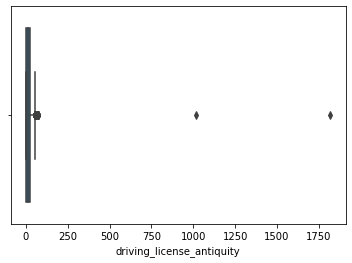

In [237]:
sns.boxplot(x=data['driving_license_antiquity'])
plt.show()

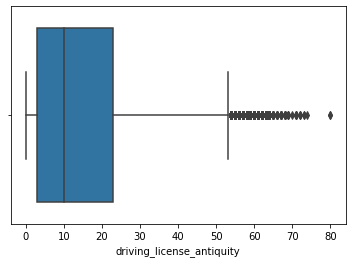

In [238]:
data['driving_license_antiquity'] = np.where(data['driving_license_antiquity']>80, 80, data['driving_license_antiquity'])
sns.boxplot(x=data['driving_license_antiquity'])
plt.show()

In [239]:
data.dtypes

file_code                     object
district_id                    int32
district_name                 object
neighborhood_id                int32
neighborhood_name             object
street_id                      int32
street_name                   object
postal_code                   object
weekday_name                  object
weekday_name_shortcut         object
day_type                      object
year                           int64
month                          int64
month_name                    object
day                            int64
hour                           int64
pedestrian_cause              object
vehicle_type                  object
vehicle_model                 object
vehicle_brand                 object
vehicle_color                 object
driving_license               object
driving_license_antiquity      int32
x_coordinate                 float64
y_coordinate                 float64
dtype: object

In [240]:
# Transform UTM coordinates to lon, lat coordinates

coor = data[['x_coordinate', 'y_coordinate']]
myProj = Proj(proj='utm',zone=31,ellps='WGS84', preserve_units=False)
lon, lat = myProj(coor['y_coordinate'].values, data['x_coordinate'].values, inverse=True)
UTMx, UTMy = myProj(lon, lat)
coor = pd.DataFrame(np.c_[UTMx, UTMy, lon, lat], columns=['UTMx', 'UTMy', 'lon', 'lat'])
coor = coor.replace(np.inf,0)
coor['lon'][coor['lon'] < 0] = 0
coor['lat'][coor['lat'] < 0] = 0
data = pd.concat([data.drop(['x_coordinate', 'y_coordinate'], axis=1).reset_index(), coor], axis=1)
data = data.drop(['index'], axis=1)


In [241]:
# save the dataframe in a csv file

data.index.name="Index"

data.to_csv('accidents_in_Barcelona.csv', sep=';')


In [242]:
data

,file_code,district_id,district_name,neighborhood_id,neighborhood_name,street_id,street_name,postal_code,weekday_name,weekday_name_shortcut,...,vehicle_type,vehicle_model,vehicle_brand,vehicle_color,driving_license,driving_license_antiquity,UTMx,UTMy,lon,lat
Index,,,,,,,,,,,,,,,,,,,,,
0,2011S000833,2,Eixample,8,l'Antiga Esquerra de l'Eixample,18505,Aragó,2 140 216,Monday,Mo,...,Car,206,PEUGEOT,White,B,9,429861.51,4582403.96,2.161064,41.390110
1,2011S000835,4,Les Corts,19,les Corts,144601,Diagonal,0652D0656D,Monday,Mo,...,Motorcycle,CY50,YAMAHA,Black,B,22,427510.22,4582622.56,2.132917,41.391870
2,2011S002871,1,Ciutat Vella,1,el Raval,34308,Rambla,910 091,Friday,Fr,...,Car,318,BMW,Black,B,7,430873.19,4581715.55,2.173242,41.383997
3,2011S000825,10,Sant Martí,71,Provençals del Poblenou,115603,Espronceda,0151X0151X,Monday,Mo,...,Motorcycle,SH 100,HONDA,Green,B,6,433383.68,4584494.10,2.202959,41.409235
4,2011S000830,5,Sarrià-Sant Gervasi,27,el Putxet i el Farró,33509,Ballester,470 047,Monday,Mo,...,Motorcycle,LIBERTY 50,PIAGGIO,Grey,B,2,428730.59,4584520.48,2.147289,41.409073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179888,2020S006276,1,Ciutat Vella,2,el Barri Gòtic,701266,Litoral (Llobregat),1070000,Thursday,Th,...,Motorcycle,AGILITY CITY 125,KYMCO,Unknown,B,16,431410.40,4581077.37,2.179739,41.378295
179889,2020S006276,1,Ciutat Vella,2,el Barri Gòtic,701266,Litoral (Llobregat),1070000,Thursday,Th,...,Others,Unknown,Unknown,Black,Unknown,0,431410.40,4581077.37,2.179739,41.378295
179890,2020S006277,2,Eixample,9,la Nova Esquerra de l'Eixample,18505,Aragó,1 270 127,Thursday,Th,...,Motorcycle,SH 150,HONDA,Red,A,25,429362.84,4581954.15,2.155152,41.386015


In [243]:
password = getpass.getpass()

········


In [244]:
# get the data
connection_string = 'mysql+pymysql://root:' + password + '@localhost/accidents'
engine = create_engine(connection_string)
query = 'SELECT * FROM barcelona_accidents;'

data = pd.read_sql_query(query, engine).drop(['id'], axis=1)
data.head()

,file_code,district_id,district_name,neighborhood_id,neighborhood_name,street_id,street_name,postal_code,weekday_name,weekday_name_shortcut,...,vehicle_type,vehicle_model,vehicle_brand,vehicle_color,driving_license,driving_license_antiquity,UTM_x,UTM_y,lon,lat
0,2011S000833,2,Eixample,8,l'Antiga Esquerra de l'Eixample,18505,Aragó,2 140 216,Monday,Mo,...,Car,206,PEUGEOT,White,B,9,429861.51,4582403.96,2.161064,41.390110
1,2011S000835,4,Les Corts,19,les Corts,144601,Diagonal,0652D0656D,Monday,Mo,...,Motorcycle,CY50,YAMAHA,Black,B,22,427510.22,4582622.56,2.132917,41.391870
2,2011S002871,1,Ciutat Vella,1,el Raval,34308,Rambla,910 091,Friday,Fr,...,Car,318,BMW,Black,B,7,430873.19,4581715.55,2.173242,41.383997
3,2011S000825,10,Sant Martí,71,Provençals del Poblenou,115603,Espronceda,0151X0151X,Monday,Mo,...,Motorcycle,SH 100,HONDA,Green,B,6,433383.68,4584494.10,2.202959,41.409235
4,2011S000830,5,Sarrià-Sant Gervasi,27,el Putxet i el Farró,33509,Ballester,470 047,Monday,Mo,...,Motorcycle,LIBERTY 50,PIAGGIO,Grey,B,2,428730.59,4584520.48,2.147289,41.409073


In [245]:
# column day_type only has one value
data = data.drop(['day_type'], axis=1)
# some columns can be dropped because they have the same information than others
data = data.drop(['weekday_name_shortcut', 'weekday_name', 'month_name'], axis=1)
# I drop all the that have the same information in a numerical id column
data = data.drop(['district_name', 'neighborhood_name', 'street_name'], axis=1)

def color_agroupation(x):
    if x in ['Orange', 'Golden', 'Violet', 'Pink']:
        return 'Others'
    elif x in ['Black/Yellow']:
        return 'Black'
    else:
        return x    

data['vehicle_color'] = data['vehicle_color'].apply(color_agroupation)



In [246]:
# From the following report I have the percentage of color vehicles in Europe
# https://www.axalta.com/content/dam/New%20Axalta%20Corporate%20Website/Documents/Brochures/axalta-regional-color-popularity-graphics-2020.pdf
temp = {'vehicle_color': ['Grey', 'White', 'Black', 'Blue', 'Silver', 'Red', 'Brown', 'Beige', 'Green', 'Yellow', 'Others'],
        'perc': [0.25, 0.25, 0.21, 0.1, 0.09, 0.05, 0.01, 0.01, 0.01, 0.01, 0.01]}
color_perc = pd.DataFrame(temp)

data = pd.merge(left = data, right = color_perc, how = 'inner', left_on = "vehicle_color", right_on= "vehicle_color")


In [247]:
numericals = data.select_dtypes(np.number).drop(['neighborhood_id'], axis=1)
categoricals = data.select_dtypes(object)

In [248]:
categoricals.head(10)

,file_code,postal_code,pedestrian_cause,vehicle_type,vehicle_model,vehicle_brand,vehicle_color,driving_license
0,2011S000833,2 140 216,Not pedestrian cause,Car,206,PEUGEOT,White,B
1,2011S001786,20 002,Not pedestrian cause,Truck,370,RENAULT,White,C
2,2011S002891,1 010 101,Not pedestrian cause,Van,BERLINGO,CITROEN,White,B
3,2011S002324,100 010,Not pedestrian cause,Car,LEON,SEAT,White,B
4,2011S002325,650 065,Not pedestrian cause,Truck,TG360,MAN,White,E D
5,2011S000982,870 087,Not pedestrian cause,Car,45,ROVER,White,B
6,2011S001352,370 037,Not pedestrian cause,Motorcycle,SYMPHONY,SYM,White,B
7,2011S001353,190 019,Not pedestrian cause,Motorcycle,SCOOPY 50,HONDA,White,A
8,2011S001094,90 009,Not pedestrian cause,Car,205,PEUGEOT,White,B
9,2011S001382,3 630 363,Not pedestrian cause,Motorcycle,PS 125,HONDA,White,B


In [249]:
numericals.head(10)

,district_id,street_id,year,month,day,hour,driving_license_antiquity,UTM_x,UTM_y,lon,lat,perc
0,2,18505,2011,2,7,16,9,429861.51,4582403.96,2.161064,41.390110,0.25
1,9,15052,2011,3,16,15,5,432782.05,4588811.55,2.195281,41.448070,0.25
2,4,330708,2011,4,29,14,9,427957.98,4582497.49,2.138287,41.390784,0.25
3,8,356905,2011,4,5,19,0,430986.47,4587702.93,2.173914,41.437933,0.25
4,10,75702,2011,4,5,18,5,433378.04,4582999.35,2.203056,41.395771,0.25
5,9,296202,2011,2,12,16,15,432390.13,4587005.70,2.190792,41.431773,0.25
6,5,13909,2011,2,26,12,18,428566.56,4583193.63,2.145483,41.397108,0.25
7,2,23403,2011,2,26,13,21,429978.34,4582229.94,2.162481,41.388553,0.25
8,7,75553,2011,2,17,8,2,429590.68,4588194.79,2.157151,41.442242,0.25
9,2,144601,2011,2,28,8,7,430127.00,4583391.06,2.164125,41.399024,0.25


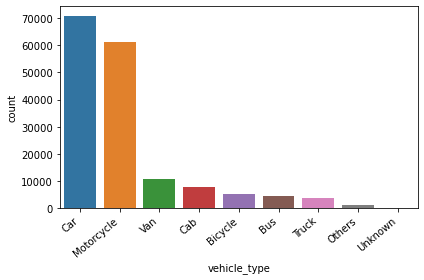

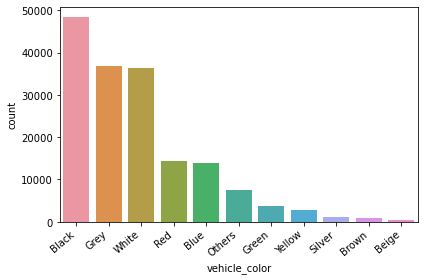

In [250]:
for column in categoricals[['vehicle_type', 'vehicle_color']]:
    ax = sns.countplot(x=categoricals[column], order=categoricals[column].value_counts().index)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.tight_layout()
    plt.show()

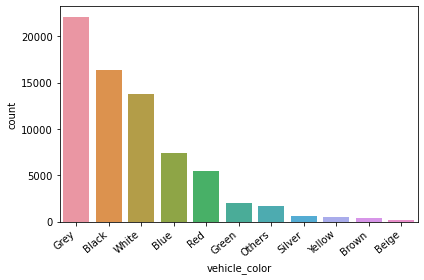

In [251]:
# vehicle_type == "Car"
ax = sns.countplot(x='vehicle_color', data=categoricals[categoricals['vehicle_type'] == 'Car'], order=categoricals[categoricals['vehicle_type'] == 'Car']['vehicle_color'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [252]:
color_perc

,vehicle_color,perc
0,Grey,0.25
1,White,0.25
2,Black,0.21
3,Blue,0.10
4,Silver,0.09
5,Red,0.05
6,Brown,0.01
7,Beige,0.01
8,Green,0.01
9,Yellow,0.01


In [253]:
data_cars = data[data['vehicle_type'] == 'Car']
data_cars

,file_code,district_id,neighborhood_id,street_id,postal_code,year,month,day,hour,pedestrian_cause,...,vehicle_model,vehicle_brand,vehicle_color,driving_license,driving_license_antiquity,UTM_x,UTM_y,lon,lat,perc
0,2011S000833,2,8,18505,2 140 216,2011,2,7,16,Not pedestrian cause,...,206,PEUGEOT,White,B,9,429861.51,4582403.96,2.161064,41.390110,0.25
3,2011S002324,8,45,356905,100 010,2011,4,5,19,Not pedestrian cause,...,LEON,SEAT,White,B,0,430986.47,4587702.93,2.173914,41.437933,0.25
5,2011S000982,9,60,296202,870 087,2011,2,12,16,Not pedestrian cause,...,45,ROVER,White,B,15,432390.13,4587005.70,2.190792,41.431773,0.25
8,2011S001094,7,43,75553,90 009,2011,2,17,8,Not pedestrian cause,...,205,PEUGEOT,White,B,2,429590.68,4588194.79,2.157151,41.442242,0.25
10,2011S001068,4,19,221305,20 002,2011,2,16,13,Not pedestrian cause,...,SEICENTO,FIAT,White,B,30,428122.61,4582510.91,2.140254,41.390920,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165983,2020S005031,10,70,195409,500 050,2020,10,26,8,Not pedestrian cause,...,C4,CITROEN,Silver,B,21,434485.87,4585121.99,2.216077,41.414981,0.09
165986,2020S005775,8,46,119003,3 280 328,2020,12,4,14,Not pedestrian cause,...,ASTRA 2.2,OPEL,Silver,B,26,430597.23,4587097.33,2.169325,41.432445,0.09
165987,2020S005842,8,45,255500,1 640 164,2020,12,7,15,Not pedestrian cause,...,LEON,SEAT,Silver,B,50,431354.01,4587230.64,2.178366,41.433711,0.09
165988,2020S006012,10,65,115603,2 670 269,2020,12,16,15,Not pedestrian cause,...,Unknown,Unknown,Silver,Unknown,0,432761.09,4585118.35,2.195441,41.414805,0.09


In [254]:
# temp = {'vehicle_color': ['Grey', 'White', 'Black', 'Blue', 'Silver', 'Red', 'Brown', 'Beige', 'Green', 'Yellow', 'Others'],
#         'perc': [0.25, 0.25, 0.21, 0.1, 0.09, 0.05, 0.01, 0.01, 0.01, 0.01, 0.01]}
# color_perc = pd.DataFrame(temp)

# temp = {'color': data_cars.vehicle_color, 'perc': data_cars.vehicle_color.value_counts()/len(data_cars)}
# accidents_by_color = pd.Dataframe(temp)
temp = round((data_cars.vehicle_color.value_counts()/len(data_cars)), 4)
temp = temp.to_frame()
temp.index.name = 'vehicle_color'
temp.columns = ['perc_accidented']
temp

,perc_accidented
vehicle_color,
Grey,0.3128
Black,0.2316
White,0.1947
Blue,0.1049
Red,0.0769
Green,0.0290
Others,0.0246
Silver,0.0091
Yellow,0.0070


In [255]:
temp2 = data_cars.vehicle_color.value_counts()
temp2 = temp2.to_frame()
temp2.index.name = 'vehicle_color'
temp2.columns = ['vehicles_accidented']
temp2

,vehicles_accidented
vehicle_color,
Grey,22118
Black,16377
White,13770
Blue,7421
Red,5437
Green,2053
Others,1743
Silver,640
Yellow,497


In [256]:
results = pd.merge(left = temp, right = color_perc, how = 'inner', left_on = "vehicle_color", right_on= "vehicle_color")
results = pd.merge(left = results, right = temp2, how = 'inner', left_on = "vehicle_color", right_on= "vehicle_color")
results

,vehicle_color,perc_accidented,perc,vehicles_accidented
0,Grey,0.3128,0.25,22118
1,Black,0.2316,0.21,16377
2,White,0.1947,0.25,13770
3,Blue,0.1049,0.10,7421
4,Red,0.0769,0.05,5437
5,Green,0.0290,0.01,2053
6,Others,0.0246,0.01,1743
7,Silver,0.0091,0.09,640
8,Yellow,0.0070,0.01,497
9,Brown,0.0063,0.01,447


In [257]:
results['variation'] = round(((results['perc_accidented'] - results['perc']) / results['perc']), 4)
results.sort_values(by='variation', ascending=False)

,vehicle_color,perc_accidented,perc,vehicles_accidented,variation
5,Green,0.0290,0.01,2053,1.9000
6,Others,0.0246,0.01,1743,1.4600
4,Red,0.0769,0.05,5437,0.5380
0,Grey,0.3128,0.25,22118,0.2512
1,Black,0.2316,0.21,16377,0.1029
3,Blue,0.1049,0.10,7421,0.0490
2,White,0.1947,0.25,13770,-0.2212
8,Yellow,0.0070,0.01,497,-0.3000
9,Brown,0.0063,0.01,447,-0.3700
10,Beige,0.0030,0.01,215,-0.7000


In [258]:
results[results['perc']>0.01].sort_values(by='variation', ascending=False)

,vehicle_color,perc_accidented,perc,vehicles_accidented,variation
4,Red,0.0769,0.05,5437,0.5380
0,Grey,0.3128,0.25,22118,0.2512
1,Black,0.2316,0.21,16377,0.1029
3,Blue,0.1049,0.10,7421,0.0490
2,White,0.1947,0.25,13770,-0.2212
7,Silver,0.0091,0.09,640,-0.8989


In [259]:
results

,vehicle_color,perc_accidented,perc,vehicles_accidented,variation
0,Grey,0.3128,0.25,22118,0.2512
1,Black,0.2316,0.21,16377,0.1029
2,White,0.1947,0.25,13770,-0.2212
3,Blue,0.1049,0.10,7421,0.0490
4,Red,0.0769,0.05,5437,0.5380
5,Green,0.0290,0.01,2053,1.9000
6,Others,0.0246,0.01,1743,1.4600
7,Silver,0.0091,0.09,640,-0.8989
8,Yellow,0.0070,0.01,497,-0.3000
9,Brown,0.0063,0.01,447,-0.3700


In [260]:
results.to_csv('results.csv', sep=';')